# Installation

In [2]:
!git clone https://github.com/TheShenk/hai-nonconflict-action-learning.git

Cloning into 'hai-nonconflict-action-learning'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 83 (delta 25), reused 43 (delta 17), pack-reused 30
Unpacking objects: 100% (83/83), done.


In [1]:
!cd hai-nonconflict-action-learning/

/content/hai-nonconflict-action-learning


In [2]:
!pip install stable-baselines3[extra] pymunk pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [3]:
import gym
import gym_futbol
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
import utils
from multiagent import MultiAgentModelProxy

pygame 2.1.2 (SDL 2.0.16, Python 3.7.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Basics

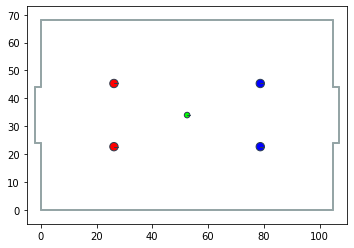

In [4]:
env = gym.make("Futbol2v2-v1")
env.render()

In [5]:
env.action_space

MultiDiscrete([5 5 5 5])

In [6]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [7]:
log_dir = "logs/"
timesteps = 10000

In [8]:
from stable_baselines3.common.env_util import make_vec_env

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = A2C("MlpPolicy", env, device='cpu')
model.learn(timesteps, progress_bar=True)
model.save("models/footbol2v2-a2c")

Output()

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# Display model statistic

    index            r   l         t
0       0   378.187545  75  0.433466
1       1   202.557519  75  0.694200
2       2   250.331103  75  0.903086
3       3  1100.582049  75  1.113872
4       4   145.750987  75  1.330194
5       5   104.665595  75  1.537557
6       6   138.923169  75  1.757039
7       7   202.112402  75  1.956216
8       8   227.618744  75  2.143835
9       9 -1123.808351  75  2.356831
10     10 -1052.554090  75  2.593371
11     11  1244.136965  75  2.820535
12     12  1307.482632  75  3.024799
13     13   310.494151  75  3.265105
14     14  -181.797039  75  3.464293
15     15   167.820157  75  3.704768
16     16   119.051271  75  3.942236
17     17  -939.483295  75  4.159012
18     18   104.184209  75  4.368962
19     19  -191.653801  75  4.584866
20     20   246.212210  75  4.810412
21     21   -72.501770  75  5.026745
22     22    96.785771  75  5.237787
23     23   332.081610  75  5.440113
24     24   -33.221804  75  5.656345
25     25    11.548320  75  5.869731
2

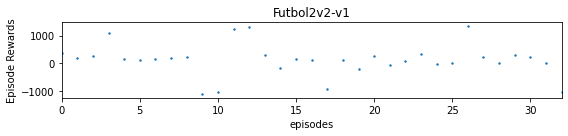

In [9]:
from IPython import display
from stable_baselines3.common import results_plotter

results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

log_data = results_plotter.load_results(log_dir)
print(log_data)

# Load model from file

In [10]:
model = A2C.load("models/footbol2v2-a2c", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [11]:
RES = WIDTH, HEIGHT = 600, 600
FPS = 60

env = gym.make("Futbol2v2-v1", width=WIDTH-2, height=HEIGHT-2, player_radius=15, ball_radius=5)
visualizer = utils.PygameVisualizer(env, FPS)
visualizer.run(model)

env.close()
visualizer.close()

error: ignored

## Matplotlib
Run model in notebook with matplotlib

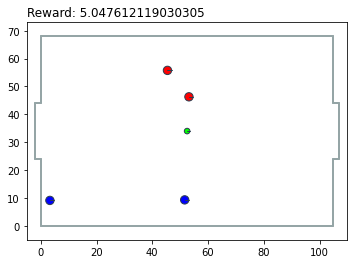

In [13]:
env = gym.make("Futbol2v2-v1")

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(model)

env.close()

# MultiAgent

## Learn

In [14]:
env = make_vec_env(lambda: gym.make("Futbol2v2-v1"), n_envs=1)

models = [
    MultiAgentModelProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[:2], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu')),
    MultiAgentModelProxy(A2C("MlpPolicy",
                             utils.TransformAction(env, lambda a: a[2:], gym.spaces.MultiDiscrete([5, 5])),
                             device='cpu'))
]

timesteps = 100
n_records_count = models[0].model.n_steps
max_episode_reward = 0

### Rewrote learning cycle
StableBaselines3 не поддерживает одновременное обучение нескольких агентов, это даже не ошибка по мнению разработчиков. Они считают, что в данном случае каждому пользователю необходимо самостоятельо переопределить цикл обучения (для не мультиагентных задач используется метод learn). Здесь представлен код, взятый из исходных кодов StableBaselines3, но адаптированный для многоагентных задач.
В обычной ситуации, learn сам взаимодействует со средой. Но при существовании нескольких агентов нужно получить действие от каждого и только потом передавать их в среду. Именно это здесь и реализовано. Каждому агенту передается наблюдение от среды (в данной задаче оно одинаково для всех) и получается действие. Затем действия объеядиняются и передаются среде. Затем каждый агент обновляется с учетом полученных данных (метод record).
Весь код, взятый из StableBaselines3 вынесен в класс MultiAgentModelProxy.

In [15]:
#TODO: рассмотреть возможность асинхронной среды
#TODO: добавить вывод логов для последующего использования results_plotter

In [16]:
for model in models:
    model.start_learning(timesteps)

for time in range(timesteps):
    done = False
    episode_reward = 0
    observation = env.reset()

    while not done:
        actions = [model.predict(observation)[0] for model in models]
        total_action = np.concatenate(np.concatenate(actions))

        for model in models:
            model.start_record()

        for step in range(n_records_count):
            next_observation, reward, done, info = env.step(np.array([total_action]))
            episode_reward += reward

            for model, action in zip(models, actions):
                model.record(observation, action, next_observation, reward, done, info)

        for model in models:
            model.end_record()
            model.train()

    if episode_reward > max_episode_reward:
        max_episode_reward = episode_reward
        for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-best-{index}")
    print(time, episode_reward)

for index, model in enumerate(models):
            model.model.save(f"models/footbol2v2-a2c-last-{index}")

0 [-1248.6316]
1 [2407.273]
2 [1138.3268]
3 [927.8263]
4 [767.90106]
5 [781.4138]
6 [186.86232]
7 [-844.1412]
8 [-717.439]
9 [786.90247]
10 [1838.8083]
11 [2022.0464]
12 [906.10657]
13 [2585.3801]
14 [894.97687]
15 [622.048]
16 [856.2044]
17 [547.0773]
18 [2167.5347]
19 [1074.0088]
20 [2445.451]
21 [2347.9258]
22 [798.2438]
23 [-980.4684]
24 [718.5801]
25 [916.4388]
26 [822.0929]
27 [1934.2527]
28 [628.5814]
29 [745.9365]
30 [593.1816]
31 [1442.6508]
32 [252.14247]
33 [519.4291]
34 [1034.1631]
35 [616.68915]
36 [597.6482]
37 [704.1699]
38 [889.28937]
39 [-778.50977]
40 [358.2773]
41 [-739.86554]
42 [448.26303]
43 [816.03656]
44 [-2192.7183]
45 [972.3682]
46 [1978.8472]
47 [2139.7766]
48 [1055.2933]
49 [571.43115]
50 [1208.9005]
51 [1029.2937]
52 [386.33722]
53 [3515.1455]
54 [2184.198]
55 [932.4228]
56 [886.35516]
57 [506.79605]
58 [3880.339]
59 [1018.5539]
60 [2263.506]
61 [2339.4421]
62 [976.42786]
63 [3636.3455]
64 [-791.4126]
65 [-1874.0784]
66 [2495.3337]
67 [3549.9087]
68 [1151.0

## Load and visualise

In [17]:
models = [A2C.load(f"models/footbol2v2-a2c-last-{index}", device="cpu") for index in range(2)]

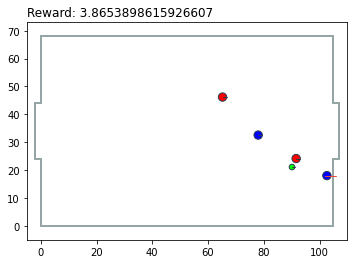

In [18]:
env = gym.make("Futbol2v2-v1")

multi_agent = utils.MultiModelAgent(models)

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(multi_agent)

env.close()